In [1]:
# Change this to generate a different set of dice throws, e.g. when sampling from the data sets
RANDOM_SEED = 42

In [2]:
# Most of the code written for this project can be found in the utils.py file. It contains helper functions for plotting images, labels, confusion matrices, etc. as well as some classes to be used in SciKit-learn pipelines.
from utils import (
    plot_labels_matrix,
    plot_labels_histogram,
    plot_confusion_heatmap,
    plot_confusions,
    plot_scaling,
    plot_stddev_histogram,
    plot_stddev_images,

    FlattenImage,
    ImageDenoiser,
    HOGExtractor,
)

In [3]:
# Numpy, Scikit-learn and matplotlib is also used in this notebook
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

%matplotlib inline

In [4]:
# One labeled and one unlabeled dataset is provided. Both can be found in the data/ directory. Images are stored in the X array, and labels in the y array.
dataset = np.load("data/dataset.npz")
X, y = dataset["X"], dataset["y"]

# Images depict handwritten digits, as well as the hexadecimal digits A-F. The label with index 16 represents a blank image.
label_mapping = {i: hex(i)[2:].upper() for i in range(16)}
label_mapping[16] = "blank"

# Each image is 20x20 pixels
IMG_SHAPE = (20, 20)

In [5]:
# Pixel values are in the files stored as uint8, with the range [0, 255] representing grayscale values from black to white.
# Since there might be a need to do scaling, normalization or more advanced image processing, let's start by just up-casting everything to float32 to avoid loosing precision or having to deal with under-/overflows. New range of [0.0, 1.0] is reached by just dividing by 255.
X = X.astype(np.float32)
X /= 255.0

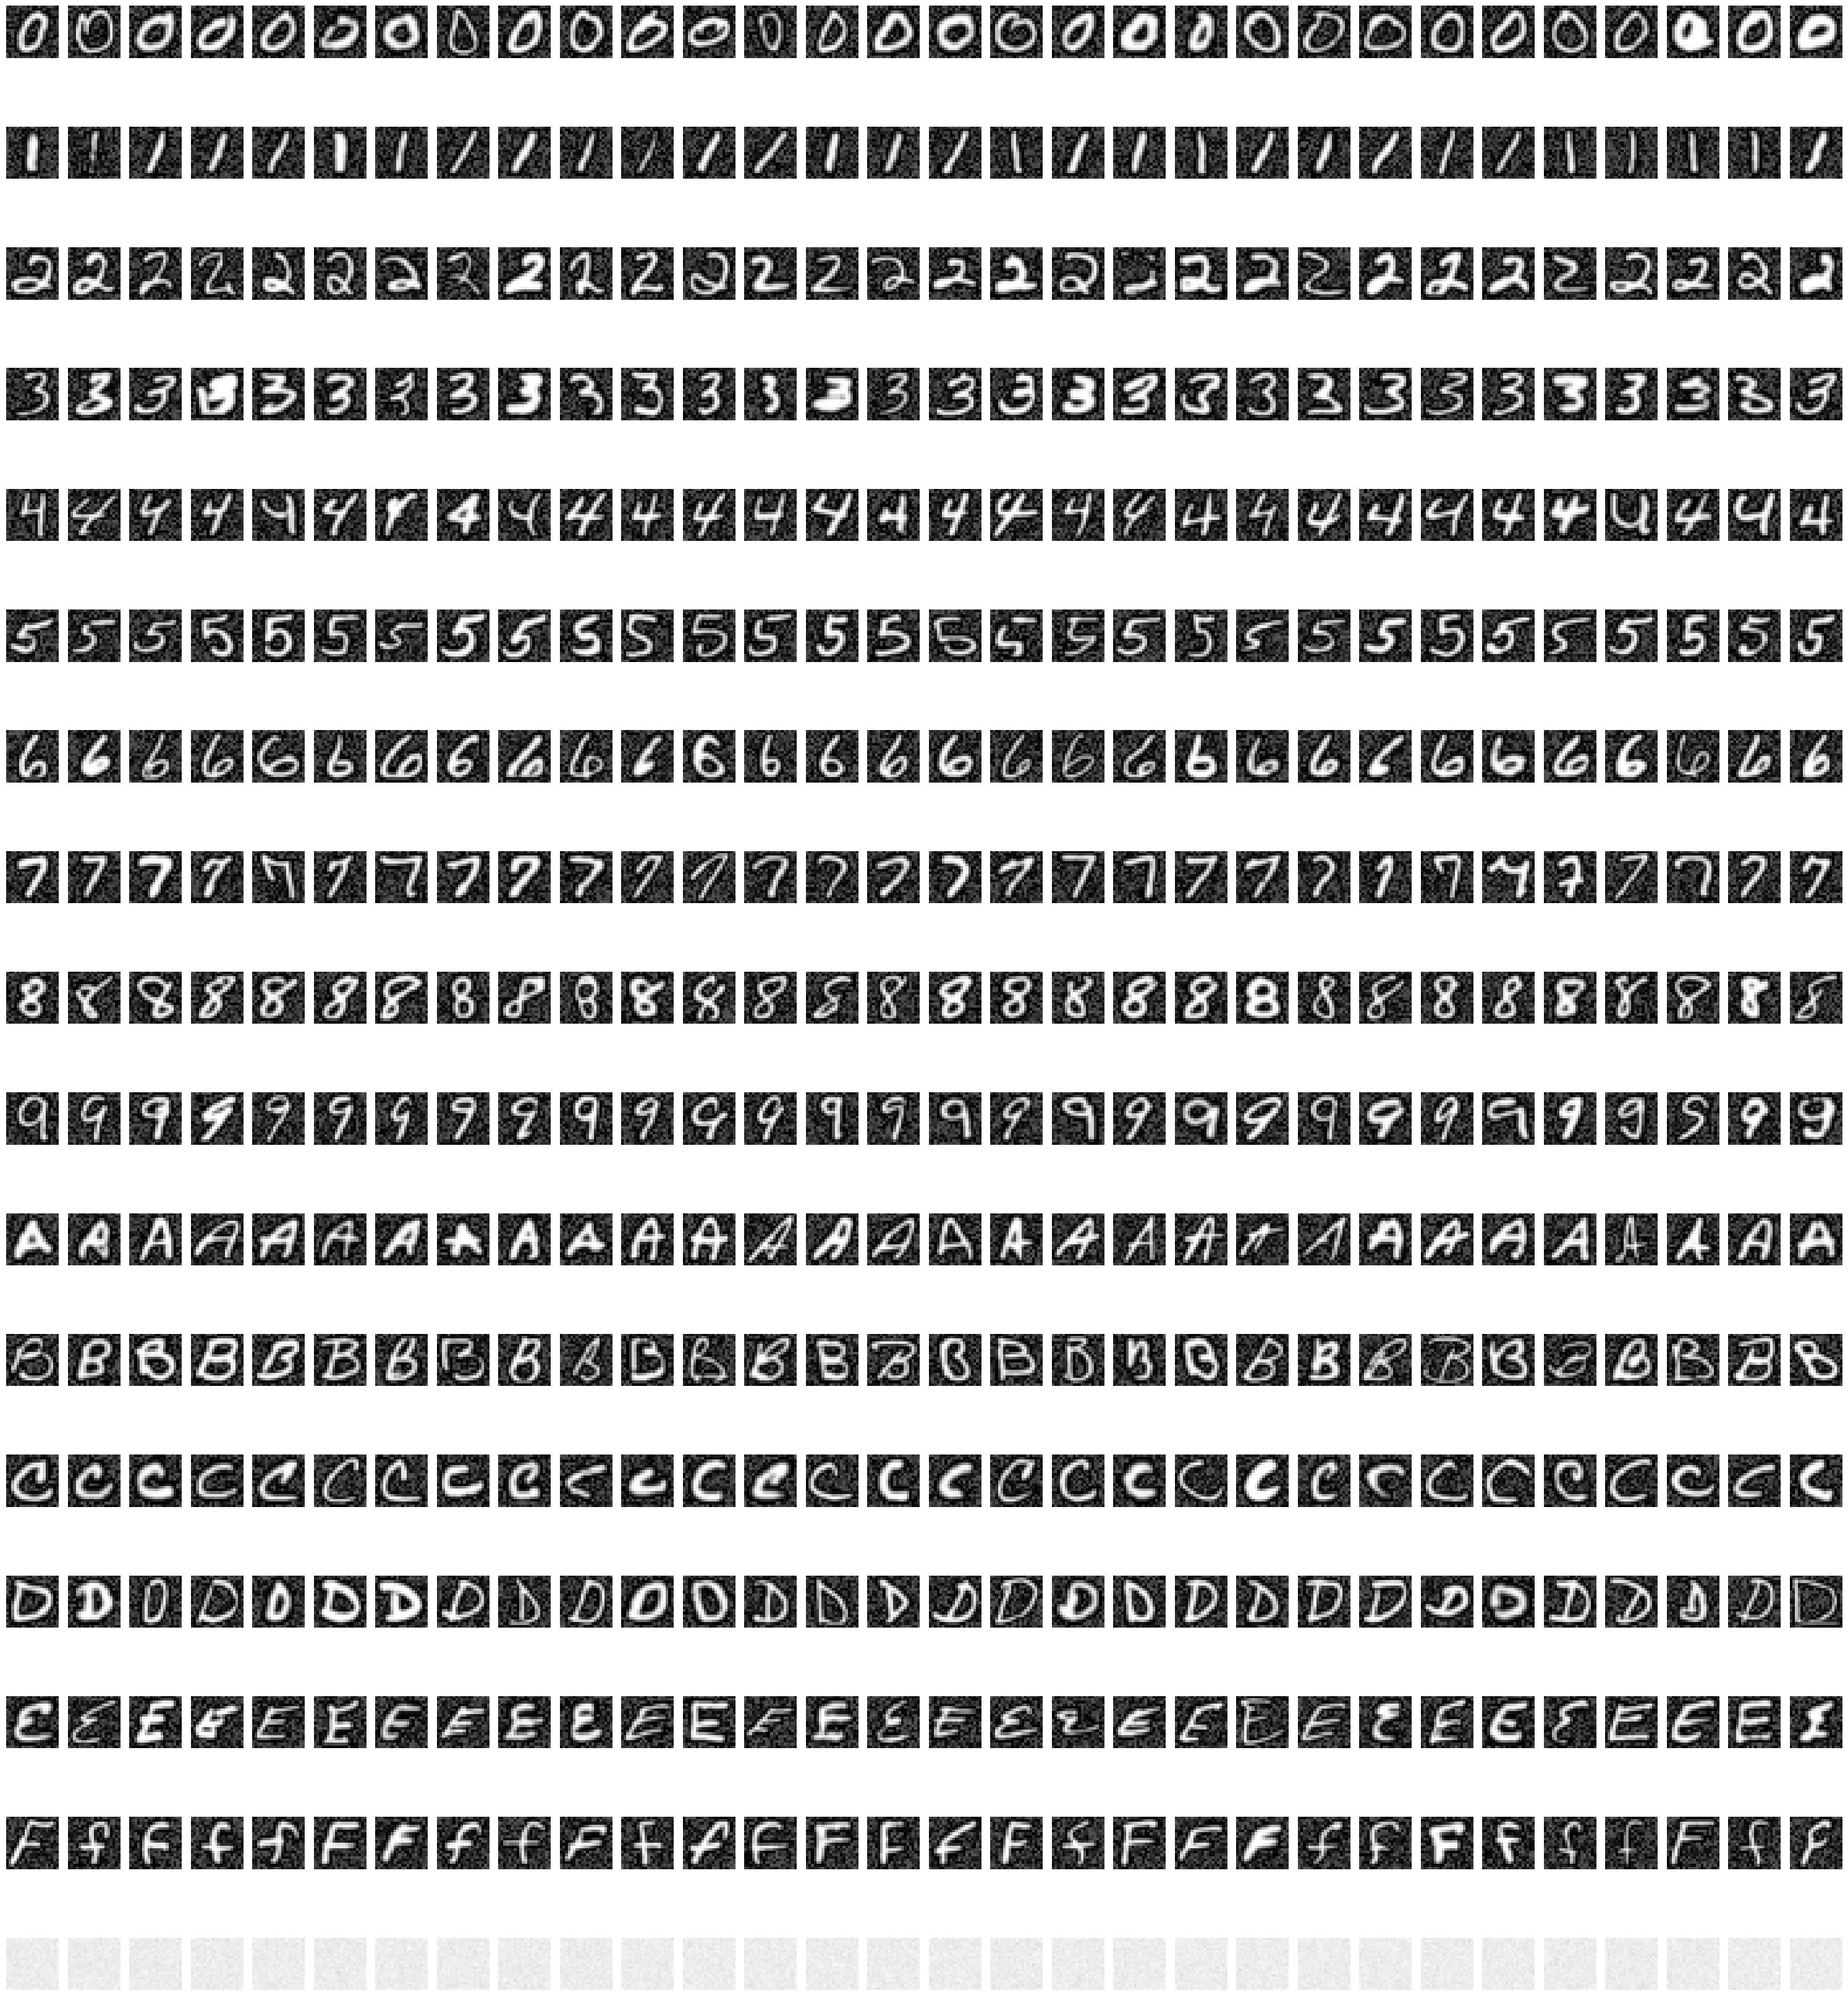

In [6]:
# Let's plot some of the images to see what they look like
plot_labels_matrix(X, y, IMG_SHAPE)

That's relatively good handwriting. Digits and letters are clearly visible, with some synthetic noise added (or all of these were written on the same type of paper).

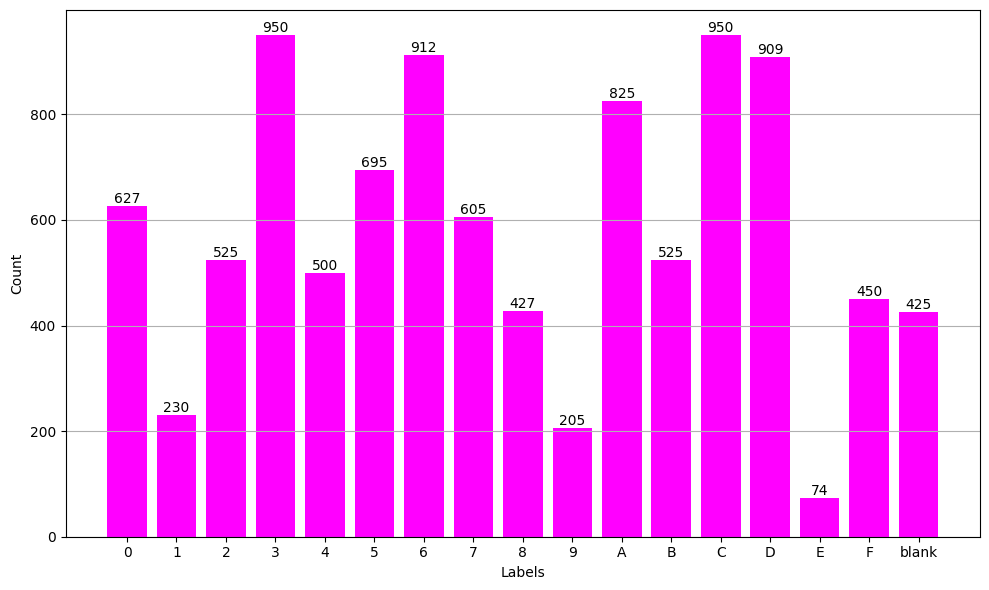

In [7]:
# When training classifiers it's useful to have an equal number of samples for each class, so let's check the distribution of samples among labels
plot_labels_histogram(y, label_mapping)

Some classes don't have many samples at all (e.g. those presenting '1', '9' and 'E'), while others have plenty. This might cause overfitting on the less represented classes, making it difficult for the classifier to recognize unseen samples belonging to those classes. To mitigate this, we could try augmentation techniques to generate more samples for the less represented classes. SMOTE is another option for oversampling that we have learned about, but it likely will not perform well on image data since it interpolates between samples' feature vectors. Linear interpolation on pixel values between neighbouring images isn't likely to produce much more than distorted and/or blurred images. 

In [8]:
# To confirm that the final model created is able to generalize well also on unseen data, we will split the dataset into training and testing sets. Holding out a test set of just 10% should be enough to get good statistical estimates at the end, since we have a relatively large dataset. The stratify parameter adjust the sampling so label distribution ends up being about the same in both the training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_SEED, stratify=y)

In [9]:
# To start, let's set up a simple classification pipeline just to get an idéa of what kind of performance we can expect with this dataset. Use the same 10% as for the training set, so the numbers obtained can be more easily compared with that later.

X_train_peek, X_test_peek, y_train_peek, y_test_peek = train_test_split(X, y, test_size=0.10, random_state=RANDOM_SEED, stratify=y)

# Hyperparameters for PCA and SVM were obtained by putting a finger in the air.
baseline_pipeline = Pipeline([
    ('pca', PCA(n_components=60, random_state=RANDOM_SEED)),
    ('svm', SVC(kernel='rbf', C=1.0, random_state=RANDOM_SEED))
])

baseline_pipeline.fit(X_train_peek, y_train_peek)

baseline_accuracy = baseline_pipeline.score(X_test_peek, y_test_peek)
baseline_accuracy

0.9247967479674797

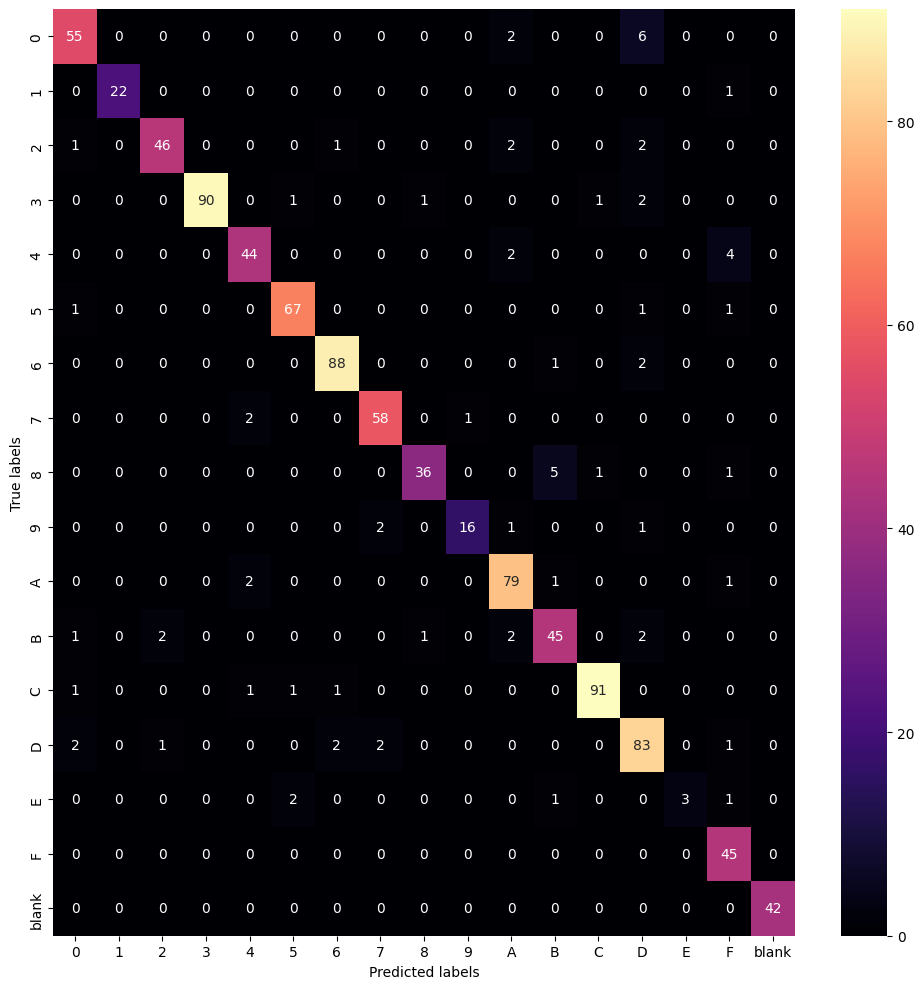

In [10]:
# 92.48%. Not too shabby.

# Let's plot the confusion matrix to see if there are any classes that are particularly problematic
y_pred_peek = baseline_pipeline.predict(X_test_peek)
plot_confusion_heatmap(y_test_peek, y_pred_peek, label_mapping)

Ooops. E got mislabeled as other characters more times than it got a correct prediction. It's also worth noting that no other characters got confused for being an E. The likely reason is that this is the character with the fewest samples in the training set by far, with a number of only 74. 8 also got confused a lot for being B's, which makes sense since the shape is similar. The reverse is however not true.

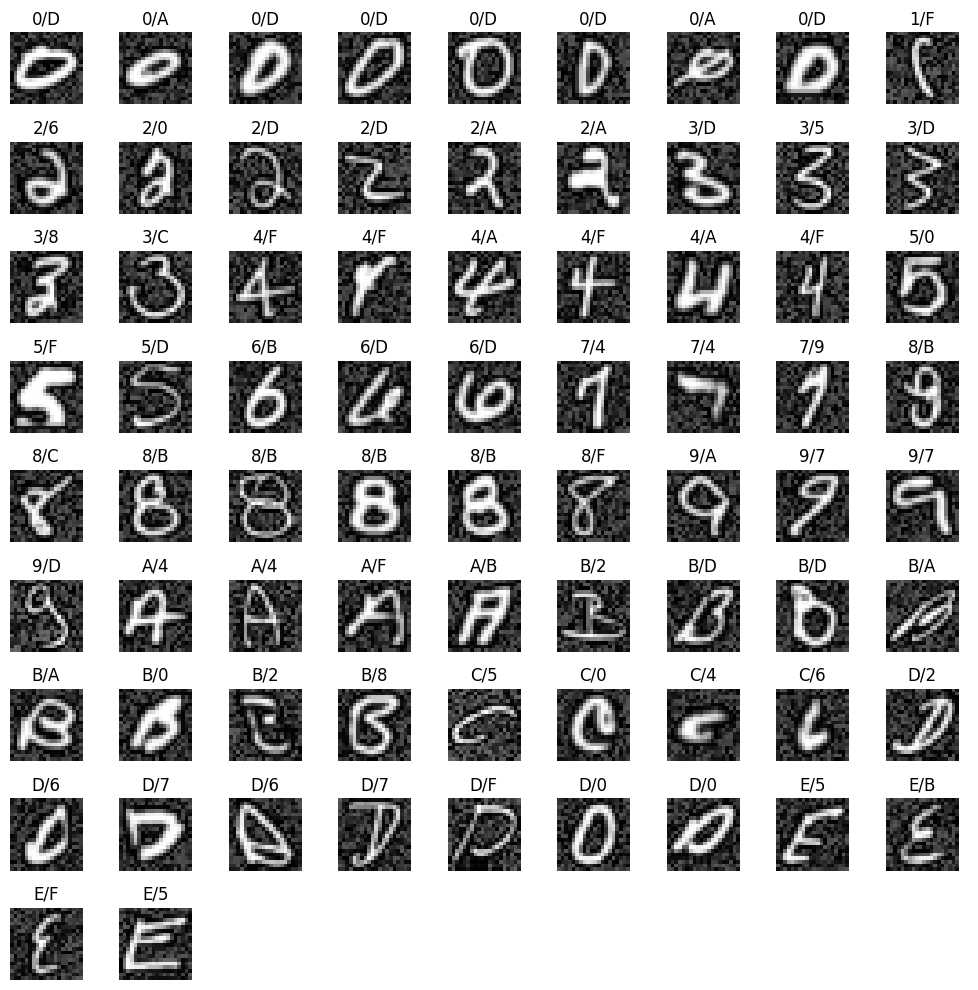

In [11]:
plot_confusions(y_test_peek, y_pred_peek, X_test_peek, label_mapping, num_samples=81)

![Anotated confusion matrix](baseline.png)

A few of the confused digits are difficult to make sense of even to my perfect human eyes. And some appear like they could have been mislabeled in the dataset. If our classifier manages to get these correct in the end, that will be a clear sign of overfitting. I count 12 of these, so the maximal achievable accuracy then shouldn't be more than roughly 1 - len(y_test_peek) / 12) = 98.78%.

In [12]:
# For the rest of this notebook manual hold-out validation will not be used. So get rid of these variables to avoid accidentally using them.
del X_train_peek, X_test_peek, y_train_peek, y_test_peek

Using Support Vector Machines (SVMs) on this dataset appears promising. They support high-dimensional feature spaces out of the box, and can through the use of kernels handle non-linearly separable data (like we should have a lot of in our images). The use of Principal Component Analysis (PCA, with or without kernels) therefore isn't strictly needed (but it might improve performance). SVMs can however be sensitive to the scaling of input features. One feature with a larger range than the others could end up dominating when SVM calculates margins or distances (with non-linear kernels) to find optimal hyperplanes. Scikit-learn has a few built-in scalers that can be used to normalize the data before feeding it to the SVM. Should any of these be included in our pipeline?

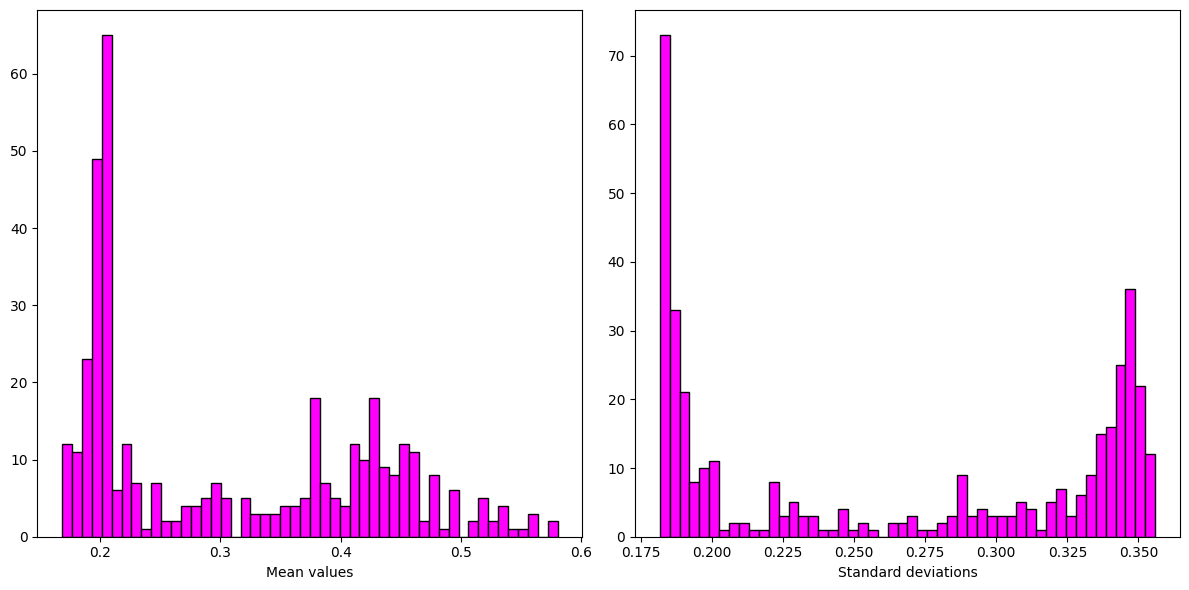

In [13]:
plot_scaling(X_train)

Since the provided images are mostly black, a big part of the pixel values are lumped together at the lower range of our scale. Whites are spread out more. This could be due to different preprocessing or exposure settings when the images were taken or adjusted, but it could also just be the ridges of each digit varying e.g. because different levels of pressure were applied to the pencil. And from looking at the images earlier, this appeared to be the case. This part of the digits however aren't likely to be important when reading/distinguishing them. The images could have been converted from greyscale to black and white (to get a classification task with binary features), and it should still be possible to read them perfectly. Applying some thresholding or adjusting contrasts could be a solution if we suspect that the chosen classifier have a problem with the white-level varying across images.

The scale we got here could have been produced by scikit-learn's MinMaxScaler. Something like this scaler could have been used to normalize the data further, but this specific class can not be used since it transforms each feature individually (e.g. every pixel across all images). By applying this the images would then end up distorted and blurry.

## Problem 1: Digit Recognizer

For finding better hyperparameters for the SVM, we'll set up a grid search. Scikit-learn's C-Support Vector Classification got a few parameters to choose from. The most important here is likely picking a kernel that is able to indirectly map our data into some higher-dimensional space where it hopefully becomes easier to separate by the use of hyperplanes. The most common choice for SVM is radial basis function (RBF) kernel. RBF is likely what also will work best for us, but let's try all the other options just to be certain. All of these kernels also got a parameter called gamma, that controls how much one training sample is able to influence the decision boundaries. The polynomial kernel also got an option called degree, which simply sets the degree on the polynomial used.

The C parameter is a regularization parameter that controls the trade-off between having a smooth decision boundary and classifying the training points correctly. A small C will make the decision boundary smooth (high regularization), while a large C will try to classify all training points correctly. This parameter is also included in the grid search.

Since Santa wants to maximize the number of children getting exactly what they had on the top of their wish list, we will only care about accuracy as a performance measure. As underrepresented classes in our training data is likely to become our final classifier's weak point, we'll however weight correct predictions in these classes higher. By setting the scoring parameter to 'balanced_accuracy' in the grid search, we handle class imbalance by giving equal weights to each class, regardless of how many samples are in each class. Hopefully the distribution present types on children's wish lists are more equal, or we might have made a mistake here.

Only 2 folds is used for cross validation, for one reason. Speed. Execution time scales roughly quadratically with the number of training samples for SVC with a non-linear kernel. With two folds, the training set is split in half. Two folds also means that we only try all combinations in our hyperparameter grid twice. Using half the data in the validation set will give a more than good enough measure of performance/accuracy, but we could risk that the hyperparameters found won't be the best when later they are used to train our final model with all available samples.

In [14]:
from sklearn.model_selection import GridSearchCV

svc_pipeline = Pipeline([
    ('svc', SVC(random_state=RANDOM_SEED))
])

svc_hyperparameters = {
    'svc__C': [5, 10, 15],
    'svc__kernel': ['poly', 'rbf', 'poly', 'sigmoid'],
    'svc__gamma': [0.1, 'scale', 'auto'],
    'svc__degree': [2, 3],
}

grid_search_svc = GridSearchCV(svc_pipeline, svc_hyperparameters, scoring='balanced_accuracy', cv=2, verbose=1, n_jobs=-1)

grid_search_svc.fit(X_train, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2, estimator=Pipeline(steps=[('svc', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svc__C': [5, 10, 15], 'svc__degree': [2, 3],
                         'svc__gamma': [0.1, 'scale', 'auto'],
                         'svc__kernel': ['poly', 'rbf', 'poly', 'sigmoid']},
             scoring='balanced_accuracy', verbose=1)

That took 1.52 seconds per fit on my machine.

In [15]:
# Remember that this measure can't be directly compared to the accuracy obtained earlier, since both the scoring function and the size of training and validation sets differ.
print("Best accuracy:", grid_search_svc.best_score_)
print("Best hyperparameters:", grid_search_svc.best_params_)

best_model = grid_search_svc.best_estimator_
best_accuracy = grid_search_svc.best_score_
best_pipeline = svc_pipeline
best_parameters = grid_search_svc.best_params_

Best accuracy: 0.8867085821709367
Best hyperparameters: {'svc__C': 10, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


Let's try something more primitive. Gradient boosted decision trees (GBDT) is an ensemble learning method on top of decision trees, similar to random forests. Unlike random forests where each tree is built from bootstrapped samples, and where all the trees can be built in parallel, GBDT builds trees sequentially, where each new tree tries to correct the errors made by the previous trees. The trees are therefore built in a greedy manner, where the tree that minimizes the loss function the most is added to the ensemble. This is done until a stopping criterion is met, e.g. a maximum number of trees or a minimum improvement in the loss function.

Decision trees can handle high dimensional data (also with non-linear relationships), but it could take time evaluating a lot of features when training them.

It's possible to use PCA also with the kernel trick, like with SVM. The same kernels (and their parameters) can be used to map features into a higher-dimensional space, before PCA extracts the most important principal components from that space, helping reduce the dimensionality while preserving non-linear relationships.

In [16]:
xgb_pipeline = Pipeline([
    ('kpca', KernelPCA(kernel='rbf', random_state=RANDOM_SEED)),
    ('xgb', XGBClassifier(eval_metric='mlogloss', learning_rate=0.01, subsample=0.8, random_state=RANDOM_SEED))
])

xgb_hyperparameters = {
    'kpca__n_components': [40, 50, 60],
    'kpca__gamma': [0.01, None],
    
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 4],
}

grid_search_xgb = GridSearchCV(xgb_pipeline, xgb_hyperparameters, cv=2, scoring='balanced_accuracy', verbose=2, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('kpca',
                                        KernelPCA(kernel='rbf',
                                                  random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_pol...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'kpca__gamma': [0.01, None],
                         'kpca__n_components': [40, 50, 60],
                         'xgb__max_depth': [3, 4],
                         'xgb__n_estimators': [100, 200]},
             scoring='balanced_accuracy', verbose=2)

That took 6.1 seconds per fit on my machine.

In [17]:
print("Best accuracy:", grid_search_xgb.best_score_)
print("Best hyperparameters:", grid_search_xgb.best_params_)

if grid_search_xgb.best_score_ > best_accuracy:
    best_model = grid_search_xgb.best_estimator_
    best_pipeline = xgb_pipeline
    best_parameters = grid_search_xgb.best_params_

Best accuracy: 0.6997959123824053
Best hyperparameters: {'kpca__gamma': 0.01, 'kpca__n_components': 50, 'xgb__max_depth': 4, 'xgb__n_estimators': 200}


## Problem 2: Dimensionality Reduction

Another way of doing dimensionality reduction is by doing feature extraction. Histogram of Oriented Gradients (HOG) is a method often used in computer vision tasks to detect and describe structures of objects within images. HOG finds gradient intensity changes (or edges), and creates a histogram representing how these gradients are distributed across different parts of the image. Three parameters are of importance to us. Orientations is the number of bins in the histogram, and 9 and 12 are commonly used values. Pixels per cell is the size of the cell that the histogram is calculated over, and 8x8 is a common choice. Cells are then grouped together to form blocks, and the number of cells in each block is the third parameter. (Blocks are also normalized, and L2-Hys is just the common method for this).

In [18]:
X_train2D = X_train.reshape(-1, *IMG_SHAPE)

hog_pipeline = Pipeline([
    ('hog', HOGExtractor()),
    ('scaler', 'passthrough'),
    ('svc', SVC(kernel='rbf', gamma='scale', probability=True, random_state=RANDOM_SEED))
])

hog_hyperparameters = {
    'hog__pixels_per_cell': [(4, 4), (5, 5), (6, 6)],
    'hog__cells_per_block': [(2, 2), (3, 3)],
    'hog__orientations': [9, 12],
    
    'scaler': [StandardScaler(), 'passthrough'],
    
    'svc__C': [1, 10, 20],
}

grid_search_hog = GridSearchCV(hog_pipeline, hog_hyperparameters, cv=2, scoring='balanced_accuracy', verbose=2, n_jobs=-1)

grid_search_hog.fit(X_train2D, y_train)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('hog', HOGExtractor()),
                                       ('scaler', 'passthrough'),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'hog__cells_per_block': [(2, 2), (3, 3)],
                         'hog__orientations': [9, 12],
                         'hog__pixels_per_cell': [(4, 4), (5, 5), (6, 6)],
                         'scaler': [StandardScaler(), 'passthrough'],
                         'svc__C': [1, 10, 20]},
             scoring='balanced_accuracy', verbose=2)

That took 2.1 seconds per fit on my machine.

In [19]:
print("Best accuracy:", grid_search_hog.best_score_)
print("Best hyperparameters:", grid_search_hog.best_params_)

if grid_search_hog.best_score_ > best_accuracy:
    best_model = grid_search_hog.best_estimator_
    best_pipeline = hog_pipeline
    best_parameters = grid_search_hog.best_params_
    needs2D = True
else:
    needs2D = False

Best accuracy: 0.9136136936337804
Best hyperparameters: {'hog__cells_per_block': (3, 3), 'hog__orientations': 9, 'hog__pixels_per_cell': (5, 5), 'scaler': 'passthrough', 'svc__C': 10}


In [20]:
# Now that we have found the best model, we can train it on the entire training set and evaluate it on the test set.
from sklearn.metrics import balanced_accuracy_score, accuracy_score

best_pipeline.set_params(**best_parameters)
best_pipeline.fit(X_train.reshape(-1, *IMG_SHAPE) if needs2D else X_train, y_train)

y_pred = best_pipeline.predict(X_test.reshape(-1, *IMG_SHAPE) if needs2D else X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Balanced accuracy:", balanced_acc)
print("Accuracy:", accuracy)


Balanced accuracy: 0.9459330173762188
Accuracy: 0.9573170731707317


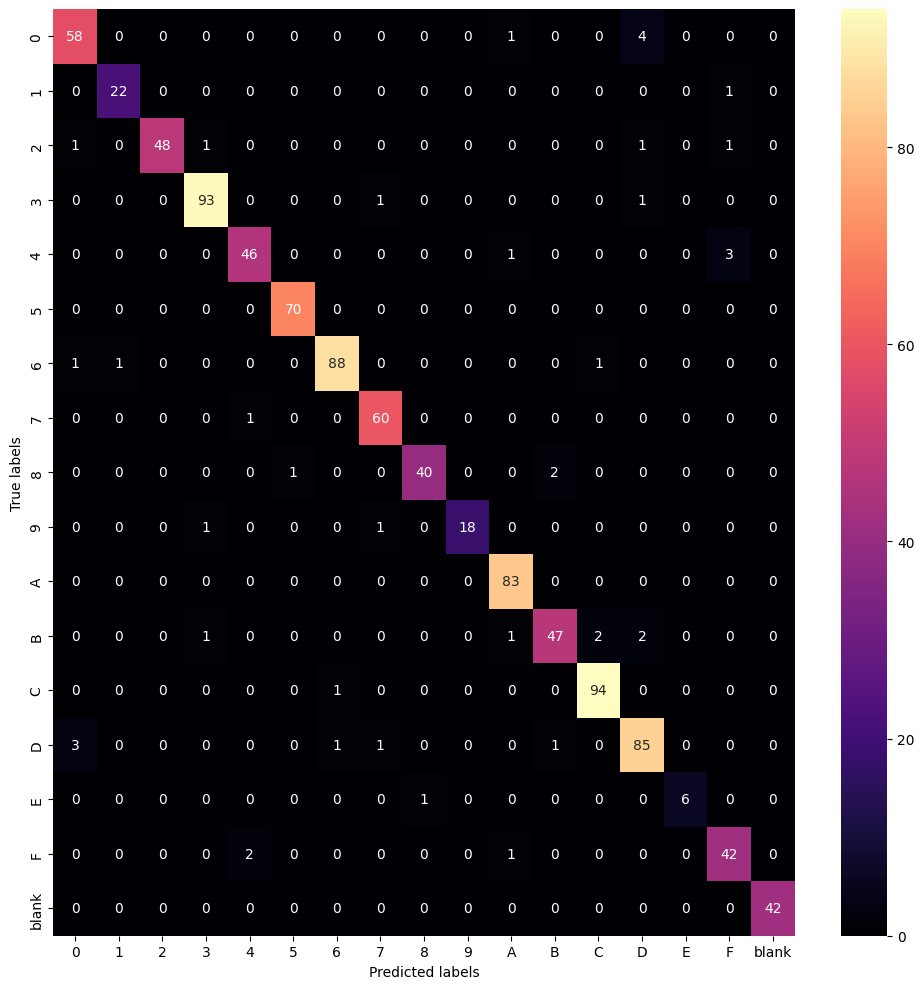

In [21]:
plot_confusion_heatmap(y_test, y_pred, label_mapping)

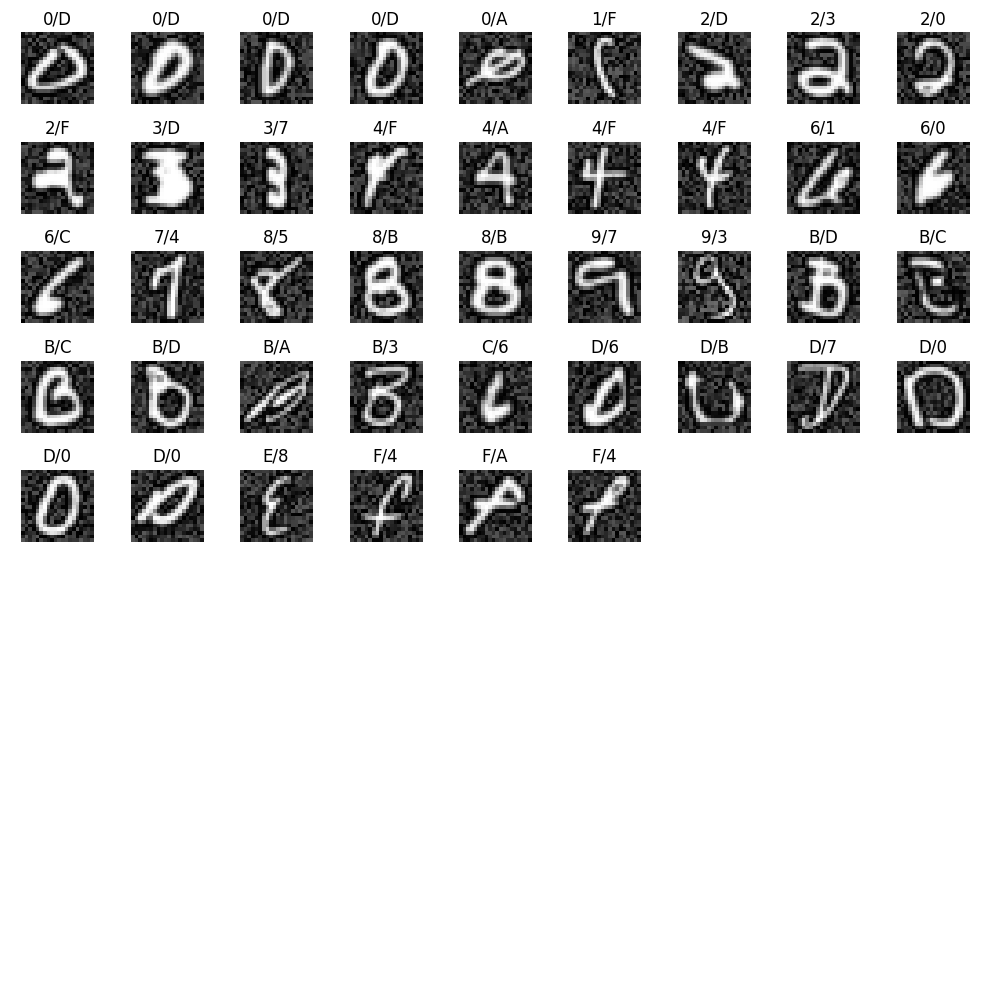

In [22]:
plot_confusions(y_test, y_pred, X_test, label_mapping, num_samples=81)

## Problem 3: Detecting Out-of-Distribution Images

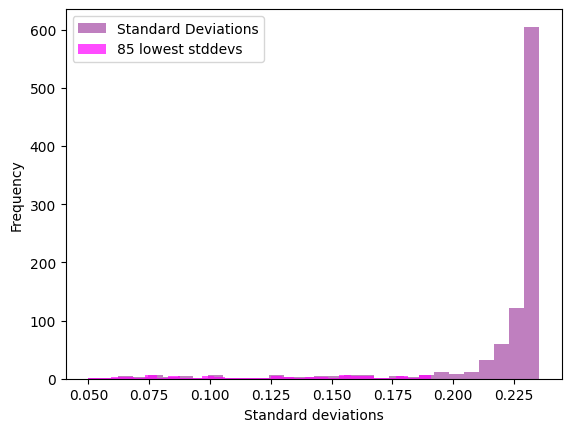

In [26]:
dataset = np.load("data/corrupt_dataset.npz")
X_c = dataset["X"]
num_ood = 85

probs = best_pipeline.predict_proba(X_c.reshape(-1, *IMG_SHAPE) if needs2D else X_c)

plot_stddev_histogram(probs, num_ood=num_ood)

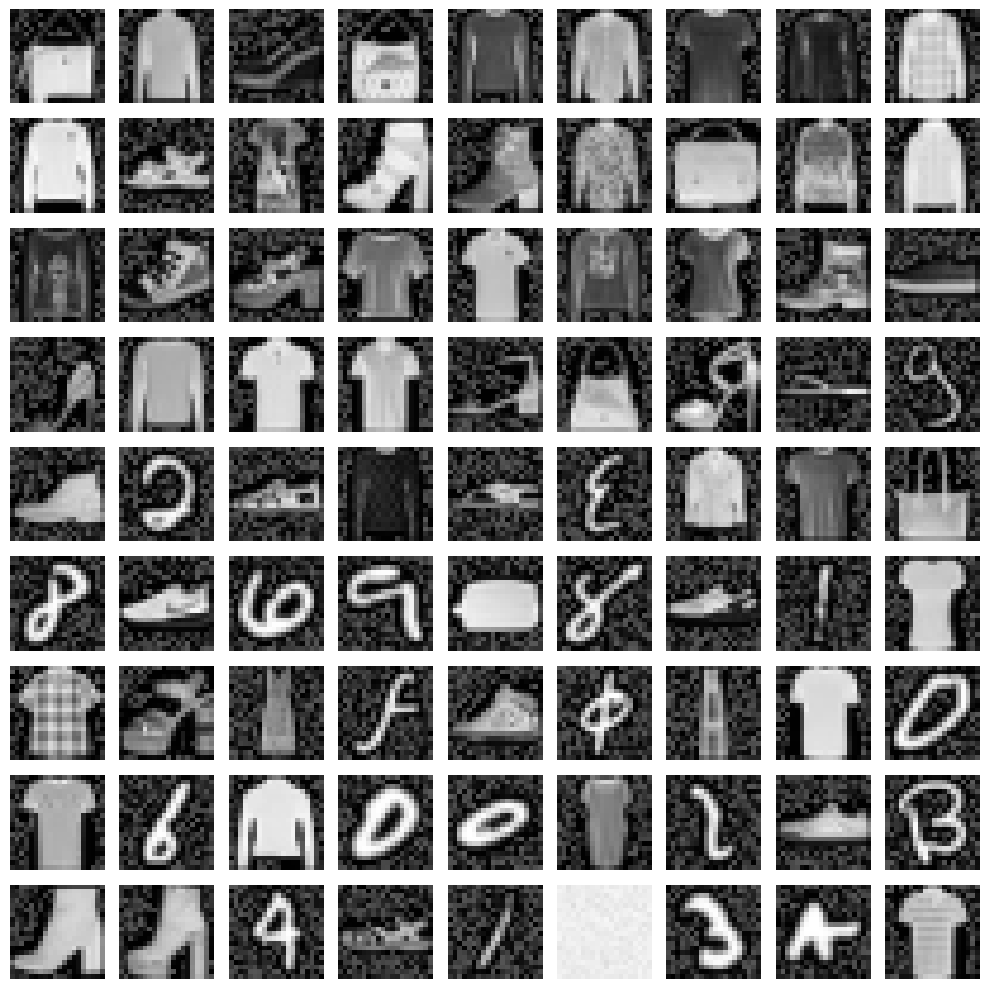

In [25]:
plot_stddev_images(X_c, probs, num_ood)
